# Applying UMAP to RFFNet

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from pyselect.datasets import make_gregorova_se1, make_gregorova_se2, make_jordan_se1
from pyselect.model import RFFNet, RFFLayer

In [2]:
seed = 0

In [3]:
rng = np.random.RandomState(0)
torch.manual_seed(seed)

## Data

In [4]:
n_samples = 800
train_size = 500
n_features = 10

In [5]:
X, y = make_jordan_se1(n_samples=n_samples, random_state=seed)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size,
                                                    random_state=seed)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [8]:
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
y_train = torch.FloatTensor(y_train)
y_val = torch.FloatTensor(y_val)

## Model

In [9]:
n_epochs = 100
batch_size = train_size//10

In [10]:
def train(n_random_features, lr=1e-2, batch_size=500, min_delta_fraction=0.8, n_iter_no_change=10):
        
    torch.manual_seed(seed)
    model = RFFNet(dims=[n_features, n_random_features, 1])
    optim_linear = torch.optim.Adam(model.linear.parameters(), lr=lr)
    optim_rff = torch.optim.Adam(model.rff.parameters(),lr=lr)

    no_improvement_count = 0
    best_val_loss = torch.Tensor([float("Inf")])
    
    criterion = torch.nn.MSELoss()
    
    adam_history = []

    model_array = np.zeros((n_epochs, max_rf + n_features))
    
    for epoch in range(n_epochs):
        indices = torch.randperm(train_size)
        model.train()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])
            
            optim_linear.zero_grad()
            loss.backward()
            optim_linear.step()

        for i in range(train_size // batch_size):
            batch = indices[i * batch_size: (i+1) * batch_size]
            pred = model(X_train[batch])

            loss = criterion(pred, y_train[batch])

            optim_rff.zero_grad()
            loss.backward()
            optim_rff.step()
                
        with torch.no_grad():
            val_loss = criterion(model(X_val), y_val)
            adam_history.append(val_loss.item())
            model_array[epoch, :n_random_features] = model.linear.weight.numpy().flatten()
            model_array[epoch, -n_features:] = np.abs(model.rff.precisions.numpy())
            
        if val_loss < min_delta_fraction*best_val_loss:
            best_model_state_dict = model.state_dict()
            best_val_loss = val_loss
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if no_improvement_count == n_iter_no_change:  
            break
          
    model.load_state_dict(best_model_state_dict)
    
    return adam_history, model_array[:epoch+1], model.state_dict()

In [11]:
max_rf = 1000

In [12]:
HYPERPARAMS = {
    "n_random_features": [25],
    "lr": np.logspace(-3, -1, 5),
    "batch_size":[50, 100, 200],
    "min_delta_fraction":[0.8, 0.9, 0.95],
    "n_iter_no_change":[5, 10, 15]
}
hyperparams = [dict(x)
               for x in itertools.product(*[[(k, v) for v in vs]
                                            for k, vs in HYPERPARAMS.items()])]

## Creating vector representations of models 

In [13]:
big_hist = []

In [14]:
arr_list = []

In [15]:
from tqdm import tqdm

In [16]:
for i, params in tqdm(enumerate(hyperparams)):
    hist, array, _ = train(**params)
    big_hist.extend(hist)
    arr_list.append(array)

135it [01:12,  1.85it/s]


In [17]:
big_arr = np.concatenate(arr_list)

In [19]:
import umap

In [20]:
reducer = umap.UMAP(densmap=True, random_state=0, n_jobs=-1)

In [21]:
reducer.fit(big_arr)

/home/mpotto/.cache/pypoetry/virtualenvs/pyselect-cxRqHTwa-py3.8/lib/python3.8/site-packages/umap/spectral.py:260: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


UMAP(densmap=True, random_state=0, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [22]:
import seaborn as sns

In [23]:
embedding = reducer.embedding_

In [24]:
colors = [ [i]*len(arr_list[i]) for i in range(len(arr_list))]

In [25]:
a = []

In [26]:
for c in colors:
    a.extend(c)

In [27]:
import matplotlib.pyplot as plt

In [28]:
xs, ys = embedding[:, 0], embedding[:, 1]

In [29]:
CMIN = min(big_hist)
CMAX = max(big_hist)

In [30]:
import matplotlib as mpl

In [31]:
mpl.rcParams['axes.spines.left']   = False
mpl.rcParams['axes.spines.right']  = False
mpl.rcParams['axes.spines.top']    = False
mpl.rcParams['axes.spines.bottom'] = False

In [32]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection


In [33]:
COLORMAP = sns.color_palette("coolwarm_r", as_cmap=True)
COLORMAP = plt.cm.plasma

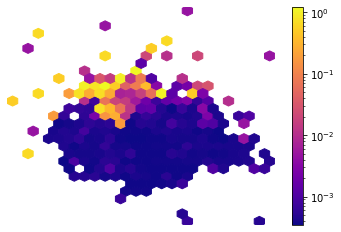

In [34]:
fig, ax= plt.subplots(1,1)
hexbins = ax.hexbin(xs, ys, C=big_hist, gridsize=25, cmap=COLORMAP)
hexbins.set_clim(CMIN, CMAX)
ax.set_xlim(xs.min()-2, xs.max()+2)
ax.set_ylim(ys.min()-2, ys.max()+2)
ax.set_xticks([])
ax.set_yticks([])
colorbar = fig.colorbar(ScalarMappable(norm=mpl.colors.LogNorm(CMIN, CMAX), cmap=COLORMAP), ax=ax)
plt.show()

In [35]:
durations = np.cumsum([arr_list[i].shape[0] for i in range(len(arr_list))])

In [36]:
big_hist[60]

0.22351819276809692

In [37]:
big_hist[59]

0.23357070982456207

In [38]:
durations

array([   6,   17,  117,  123,  223,  323,  329,  429,  529,  535,  546,
        562,  568,  579,  595,  601,  612,  712,  718,  729,  745,  751,
        762,  778,  784,  795,  811,  851,  918, 1018, 1089, 1189, 1289,
       1389, 1489, 1589, 1595, 1673, 1773, 1779, 1879, 1979, 2079, 2179,
       2279, 2285, 2296, 2312, 2318, 2329, 2345, 2351, 2362, 2462, 2493,
       2550, 2612, 2667, 2754, 2854, 2915, 3015, 3115, 3153, 3220, 3305,
       3356, 3456, 3556, 3641, 3741, 3841, 3847, 3923, 4023, 4029, 4129,
       4229, 4323, 4423, 4523, 4545, 4596, 4652, 4691, 4735, 4795, 4834,
       4889, 4965, 4992, 5033, 5103, 5139, 5198, 5298, 5341, 5425, 5525,
       5566, 5620, 5706, 5753, 5845, 5945, 6037, 6137, 6237, 6263, 6294,
       6342, 6368, 6399, 6466, 6492, 6523, 6590, 6612, 6651, 6695, 6719,
       6758, 6802, 6826, 6865, 6931, 6958, 7004, 7069, 7113, 7162, 7227,
       7272, 7348, 7429])

In [39]:
final_losses = np.array([big_hist[i-1] for i in durations])

In [58]:
min_loss = np.quantile(final_losses, 0.1)

In [59]:
selected_loss = np.max(final_losses[final_losses <= min_loss])

In [60]:
selected_loss

0.002656895900145173

In [61]:
selection = np.where(final_losses == selected_loss)[0][0]

In [62]:
selection

118

In [63]:
durations[selection]

6651

In [64]:
js = list(range(durations[selection-1], durations[selection]-1))

In [65]:
unique_pts = np.unique(np.array([xs[js], ys[js]]).T, axis=0)

In [66]:
xjs, yjs = unique_pts[:, 0], unique_pts[:, 1]

In [67]:
import scipy

In [68]:
tck, u = scipy.interpolate.splprep([xjs, yjs], s=5)

In [69]:
spline_domain = np.linspace(0, 1, 500)
spline_x, spline_y = scipy.interpolate.splev(spline_domain, tck)
spline_points = np.array([spline_x, spline_y]).T.reshape(-1, 1, 2)
spline_segments = np.concatenate([spline_points[:-1], spline_points[1:]], axis=1)

In [70]:
COLORMAP = plt.cm.plasma_r

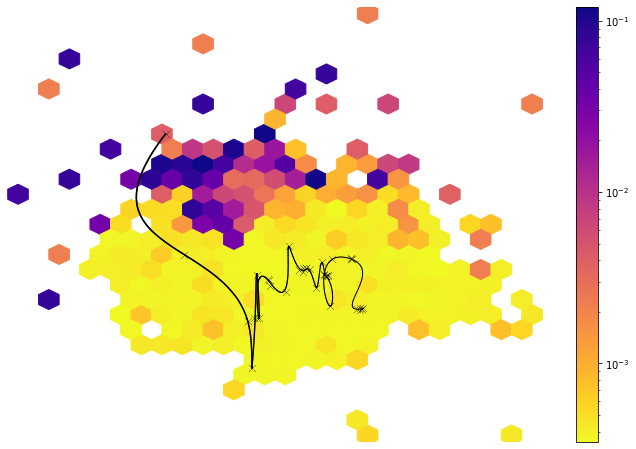

In [75]:
fig, ax= plt.subplots(1,1, figsize=(12, 8))
hexbins = ax.hexbin(xs, ys, C=big_hist, gridsize=25, cmap=COLORMAP)
hexbins.set_clim(CMIN, CMAX)
ax.set_xlim(xs.min()-2, xs.max()+2)
ax.set_ylim(ys.min()-2, ys.max()+2)
ax.set_xticks([])
ax.set_yticks([])
#plt.xlim(-8, 10)
#plt.ylim(-20, 0)

lc = LineCollection(spline_segments, linewidths=0.75*(1-spline_domain)+0.9, color='k')
lc.set_capstyle('round')
ax.add_collection(lc)
ax.scatter(xjs, yjs, marker='x', lw=0.3, s=50, c='k')

colorbar = fig.colorbar(ScalarMappable(norm=mpl.colors.LogNorm(CMIN, CMAX), cmap=COLORMAP), ax=ax)
plt.show()